In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torchsummary import summary as Summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100
batch_size = 64
lr = 5e-5
img_shape = (3, 32, 32)
n_epochs = 50
n_critic = 5
c = 0.01

print(device)

cuda


In [3]:
# Load Inception-v3 in eval mode
inception = inception_v3(pretrained=True, transform_input=False)
inception.fc = torch.nn.Identity()  # Remove final classification layer
inception.aux_logits = False
inception.eval()

if torch.cuda.is_available():
    inception = inception.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 225MB/s] 


In [4]:
def preprocess_images(images):
    """Preprocess images for Inception-v3"""
    # Ensure images are in [0, 1] range
    if images.min() >= -1.0 and images.max() <= 1.0:
        # Input is in [-1, 1] range (GAN output)
        images = (images + 1.0) / 2.0
    elif images.max() > 1.0:
        # Input is in [0, 255] range
        images = images / 255.0
    else:
        # Already in [0, 1] range
        pass
    
    # Clamp to [0, 1]
    images = torch.clamp(images, 0.0, 1.0)
    
    # Resize to 299x299
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    # ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    
    if images.is_cuda:
        mean = mean.cuda()
        std = std.cuda()
    
    images = (images - mean) / std
    return images

In [5]:
def get_features(images, model):
    """Extract features using Inception-v3 (2048D from pool3 layer)"""
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            images = images.cuda()
            
        # Preprocess images properly
        images = preprocess_images(images)
        
        # Use the standard forward pass to get pool3 features (2048D)
        # This automatically handles all the layers correctly
        features = model(images)  # This gives us the final pooled features
        
        # If features are still 2D (batch_size, features), we're good
        # If they're 4D, we need to pool them
        if len(features.shape) == 4:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = torch.flatten(features, 1)
    
    return features.cpu()

In [6]:
def calculate_stats(features):
    """Calculate mean and covariance matrix"""
    features = features.numpy().astype(np.float64)  # Use float64 for numerical stability
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

In [7]:
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate FID score"""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)
    
    # Ensure matrices are symmetric (numerical stability)
    sigma1 = (sigma1 + sigma1.T) / 2
    sigma2 = (sigma2 + sigma2.T) / 2
    
    # Add small epsilon to diagonal for numerical stability
    sigma1 += eps * np.eye(sigma1.shape[0])
    sigma2 += eps * np.eye(sigma2.shape[0])
    
    diff = mu1 - mu2
    
    # Calculate sqrt of product of covariance matrices
    try:
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    except Exception as e:
        print(f"Error in sqrtm: {e}")
        # Fallback: add more regularization
        sigma1 += eps * 10 * np.eye(sigma1.shape[0])
        sigma2 += eps * 10 * np.eye(sigma2.shape[0])
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    
    # Handle numerical errors in sqrtm
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.absolute(covmean.imag))
            raise ValueError(f"Imaginary component {m}")
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [8]:
def compute_fid(real_images, fake_images, batch_size=64):
    """Compute FID between real and fake images"""
    # Create data loaders
    real_loader = DataLoader(real_images, batch_size=batch_size, shuffle=False)
    fake_loader = DataLoader(fake_images, batch_size=batch_size, shuffle=False)
    
    # Process real images
    real_features = []
    for batch in real_loader:
        real_features.append(get_features(batch, inception))
    real_features = torch.cat(real_features, dim=0)

    # Process fake images
    fake_features = []
    for batch in fake_loader:
        fake_features.append(get_features(batch, inception))
    fake_features = torch.cat(fake_features, dim=0)

    # Calculate statistics
    mu_real, sigma_real = calculate_stats(real_features)
    mu_fake, sigma_fake = calculate_stats(fake_features)

    return calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)

In [9]:
def evaluate_fid(generator, dataloader, sample_size, batch_size_fid, latent_dim, device):
    """Evaluate FID score for a generator"""
    generator.eval()
    
    # Generate fake images
    fake_images = []
    with torch.no_grad():
        for j in range(0, sample_size, batch_size_fid):
            current_batch = min(batch_size_fid, sample_size - j)
            z = torch.randn(current_batch, latent_dim).to(device)
            fake_batch = generator(z).cpu()
            fake_images.append(fake_batch)
    fake_images = torch.cat(fake_images, dim=0)

    # Collect real images
    real_images = []
    total_collected = 0
    for imgs, _ in dataloader:
        real_images.append(imgs)
        total_collected += imgs.size(0)
        if total_collected >= sample_size:
            break
    
    real_images = torch.cat(real_images, dim=0)[:sample_size]
    
    # Ensure we have the same number of real and fake images
    min_size = min(len(real_images), len(fake_images))
    real_images = real_images[:min_size]
    fake_images = fake_images[:min_size]
    
    # Compute FID
    fid = compute_fid(real_images, fake_images)
    
    generator.train()
    return fid

In [10]:
selected_classes = [2,3,4,5,6,7]

class CIFAR10Subset(Dataset):
    def __init__(self, root, train=True, selected_labels=None, transform=None):
        self.full_dataset = datasets.CIFAR10(root=root, train=train, transform=transform, download=True)
        self.selected_labels = selected_labels if selected_labels is not None else list(range(10))
        self.indices = [i for i, (_, label) in enumerate(self.full_dataset) if label in self.selected_labels]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]
        img, label = self.full_dataset[true_idx]
        return img, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

subset = CIFAR10Subset(root='./data', train=True, selected_labels=selected_classes, transform=transform)
dataloader = DataLoader(subset, batch_size=64, shuffle=True)

100%|██████████| 170M/170M [00:16<00:00, 10.1MB/s] 


In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

generator = Generator(latent_dim).to(device)
print(Summary(generator, input_size=(latent_dim,), batch_size=batch_size, device="cuda"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [64, 8192]         827,392
              ReLU-2                 [64, 8192]               0
         Unflatten-3            [64, 128, 8, 8]               0
          Upsample-4          [64, 128, 16, 16]               0
            Conv2d-5          [64, 128, 16, 16]         147,584
       BatchNorm2d-6          [64, 128, 16, 16]             256
              ReLU-7          [64, 128, 16, 16]               0
          Upsample-8          [64, 128, 32, 32]               0
            Conv2d-9           [64, 64, 32, 32]          73,792
      BatchNorm2d-10           [64, 64, 32, 32]             128
             ReLU-11           [64, 64, 32, 32]               0
           Conv2d-12            [64, 3, 32, 32]           1,731
             Tanh-13            [64, 3, 32, 32]               0
Total params: 1,050,883
Trainable param

In [12]:
class Critic_1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 16 x 16
            
            nn.Conv2d(128,256 , kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([256, 8, 8]),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 8 x 8
            
            nn.Conv2d(256,512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([512,4,4]),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 4 x 4
            
            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic_1().to(device)
print(Summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           6,144
         LeakyReLU-2          [-1, 128, 16, 16]               0
            Conv2d-3            [-1, 256, 8, 8]         524,288
         LayerNorm-4            [-1, 256, 8, 8]          32,768
         LeakyReLU-5            [-1, 256, 8, 8]               0
            Conv2d-6            [-1, 512, 4, 4]       2,097,152
         LayerNorm-7            [-1, 512, 4, 4]          16,384
         LeakyReLU-8            [-1, 512, 4, 4]               0
 AdaptiveAvgPool2d-9            [-1, 512, 1, 1]               0
          Flatten-10                  [-1, 512]               0
           Linear-11                    [-1, 1]             513
Total params: 2,677,249
Trainable params: 2,677,249
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

In [13]:
class Critic_2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # 64 x 16 x 16
            
            nn.Conv2d(128,256 , kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.78),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # 128 x 8 x 8
            
            nn.Conv2d(256,512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=0.78),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # 256 x 4 x 4
            
            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic_2().to(device)
print(Summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           6,144
         LeakyReLU-2          [-1, 128, 16, 16]               0
         Dropout2d-3          [-1, 128, 16, 16]               0
            Conv2d-4            [-1, 256, 8, 8]         524,288
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
         Dropout2d-7            [-1, 256, 8, 8]               0
            Conv2d-8            [-1, 512, 4, 4]       2,097,152
       BatchNorm2d-9            [-1, 512, 4, 4]           1,024
        LeakyReLU-10            [-1, 512, 4, 4]               0
        Dropout2d-11            [-1, 512, 4, 4]               0
AdaptiveAvgPool2d-12            [-1, 512, 1, 1]               0
          Flatten-13                  [-1, 512]               0
           Linear-14                   

In [14]:
def show_imgs(real_imgs, gen_imgs, n=10):
    """Display real and generated images side by side"""
    n = min(n, len(real_imgs), len(gen_imgs))  # Ensure we don't exceed available images
    
    real = real_imgs[:n].cpu().detach()
    fake = gen_imgs[:n].cpu().detach()

    # Rescale from [-1, 1] to [0, 1]
    real = (real + 1) / 2
    fake = (fake + 1) / 2

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
    
    # Handle case where n=1 (axes won't be 2D)
    if n == 1:
        axes = axes.reshape(2, 1)

    for i in range(n):
        # Real images on top row
        real_img = real[i].permute(1, 2, 0).numpy()
        axes[0, i].imshow(real_img, vmin=0, vmax=1)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Real Images")

        # Fake images on bottom row
        fake_img = fake[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(fake_img, vmin=0, vmax=1)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Generated Images")

    plt.tight_layout()
    plt.show()

In [15]:
def train_WGAN(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_critic , c , n_epochs , fid_0):
    os.makedirs("images_WGAN", exist_ok=True)

    g_losses = []  
    c_losses = []
    fid_scores = []
    fid_scores.append(fid_0)  # Adding the fid value of noise genertaed by the generator before Training 

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0  # Intialised the loss variables 
        c_loss_epoch = 0.0
        batches = 0
        
        for i, (imgs, _) in enumerate(dataloader): 
            real_imgs = imgs.to(device)
            batches += 1
            c_loss_n = 0.0
            b_size = imgs.size(0)  # to track the current batch size

            for _ in range(n_critic):
                optimizer_c.zero_grad()
 
                z = torch.randn(b_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)

                loss_c = - (torch.mean(real_validity) - torch.mean(fake_validity))   # loss of Critic = max ( E(D(x)) - E(G(z)) )
                c_loss_n += loss_c.item()                                            # maximising the loss = minimising the the -ve of loss as optimizers are used to reduce the loss values 
                loss_c.backward()                                                                   
                optimizer_c.step()

                for p in critic.parameters():           # Weight Clipping 
                    p.data.clamp_(-c, c)

            c_loss_epoch += (c_loss_n / n_critic)   # taking Avg of all the losses for n_critic

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_validity = critic(gen_imgs)
            loss_g = - torch.mean(gen_validity)   # loss of Generator = min( - E(D(G(z))) ) 
            g_loss_epoch += loss_g.item()         # and we will keep it as it is as optimisers are already doing this 
            loss_g.backward()
            optimizer_g.step()
            
        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)
        
        fid_score = evaluate_fid(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID in each epoch 
        fid_scores.append(fid_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f}")

        # Printing The Results for every 25th iteration

        if epoch % 25 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_WGAN/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    # Plotting The Curves 

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("WGAN Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return fid_scores

Before Training...


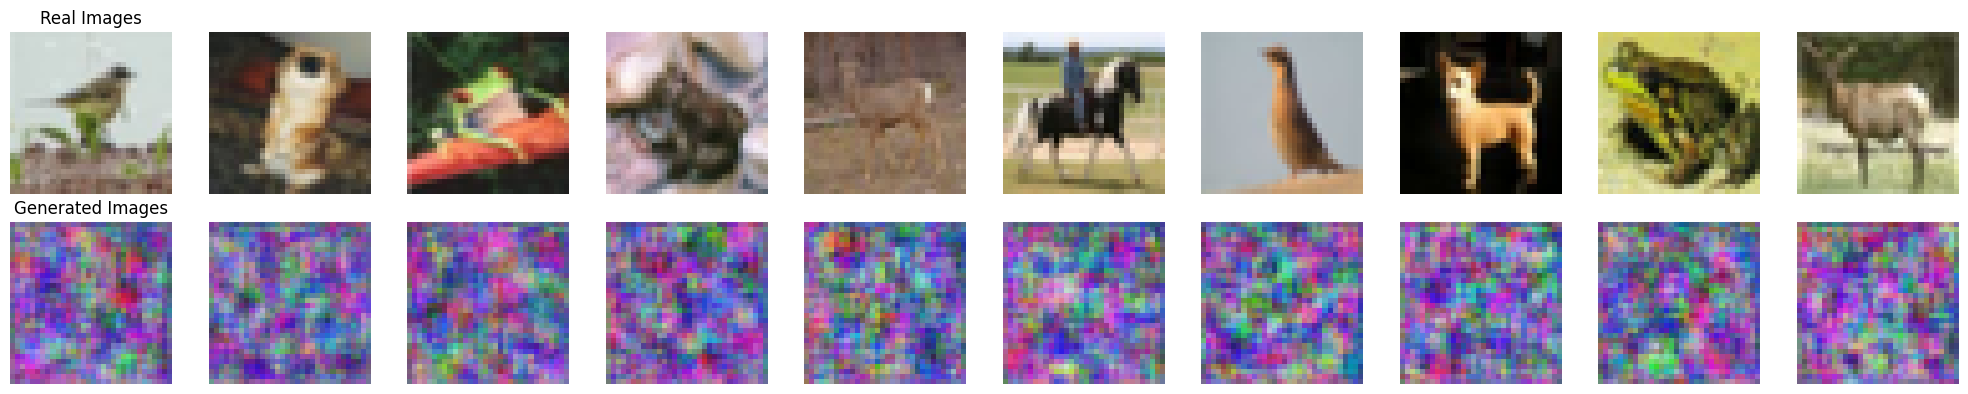

 FID : 414.20849083465686
Training started...
[Epoch 1/50] Loss D: -0.0548, Loss G: 0.0286 , FID score : 181.9890
[Epoch 2/50] Loss D: -0.0622, Loss G: 0.0307 , FID score : 138.1493
[Epoch 3/50] Loss D: -0.0636, Loss G: 0.0315 , FID score : 128.9792
[Epoch 4/50] Loss D: -0.0641, Loss G: 0.0316 , FID score : 117.0516
[Epoch 5/50] Loss D: -0.0608, Loss G: 0.0304 , FID score : 111.0502
[Epoch 6/50] Loss D: -0.0580, Loss G: 0.0290 , FID score : 102.3737
[Epoch 7/50] Loss D: -0.0558, Loss G: 0.0273 , FID score : 92.1453
[Epoch 8/50] Loss D: -0.0538, Loss G: 0.0272 , FID score : 95.4677
[Epoch 9/50] Loss D: -0.0521, Loss G: 0.0257 , FID score : 92.7002
[Epoch 10/50] Loss D: -0.0503, Loss G: 0.0251 , FID score : 89.7834
[Epoch 11/50] Loss D: -0.0486, Loss G: 0.0247 , FID score : 91.7983
[Epoch 12/50] Loss D: -0.0470, Loss G: 0.0233 , FID score : 89.2217
[Epoch 13/50] Loss D: -0.0458, Loss G: 0.0226 , FID score : 86.8019
[Epoch 14/50] Loss D: -0.0448, Loss G: 0.0225 , FID score : 84.6759
[Epoc

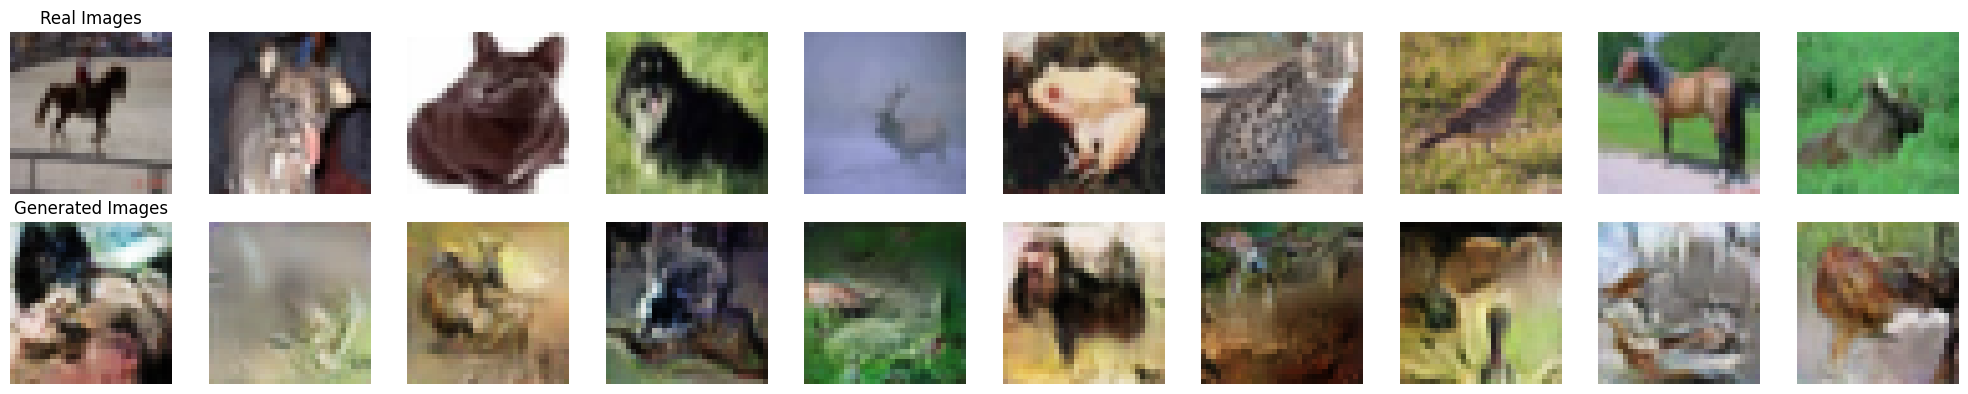

[Epoch 26/50] Loss D: -0.0350, Loss G: 0.0167 , FID score : 65.5720
[Epoch 27/50] Loss D: -0.0346, Loss G: 0.0169 , FID score : 64.6894
[Epoch 28/50] Loss D: -0.0341, Loss G: 0.0156 , FID score : 62.7585
[Epoch 29/50] Loss D: -0.0336, Loss G: 0.0162 , FID score : 63.9517
[Epoch 30/50] Loss D: -0.0331, Loss G: 0.0152 , FID score : 64.3426
[Epoch 31/50] Loss D: -0.0328, Loss G: 0.0154 , FID score : 63.1785
[Epoch 32/50] Loss D: -0.0326, Loss G: 0.0154 , FID score : 67.8167
[Epoch 33/50] Loss D: -0.0321, Loss G: 0.0158 , FID score : 61.1698
[Epoch 34/50] Loss D: -0.0318, Loss G: 0.0145 , FID score : 60.4826
[Epoch 35/50] Loss D: -0.0314, Loss G: 0.0148 , FID score : 62.6881
[Epoch 36/50] Loss D: -0.0311, Loss G: 0.0144 , FID score : 60.5911
[Epoch 37/50] Loss D: -0.0309, Loss G: 0.0146 , FID score : 59.2147
[Epoch 38/50] Loss D: -0.0306, Loss G: 0.0139 , FID score : 58.7151
[Epoch 39/50] Loss D: -0.0302, Loss G: 0.0138 , FID score : 59.7797
[Epoch 40/50] Loss D: -0.0300, Loss G: 0.0141 , 

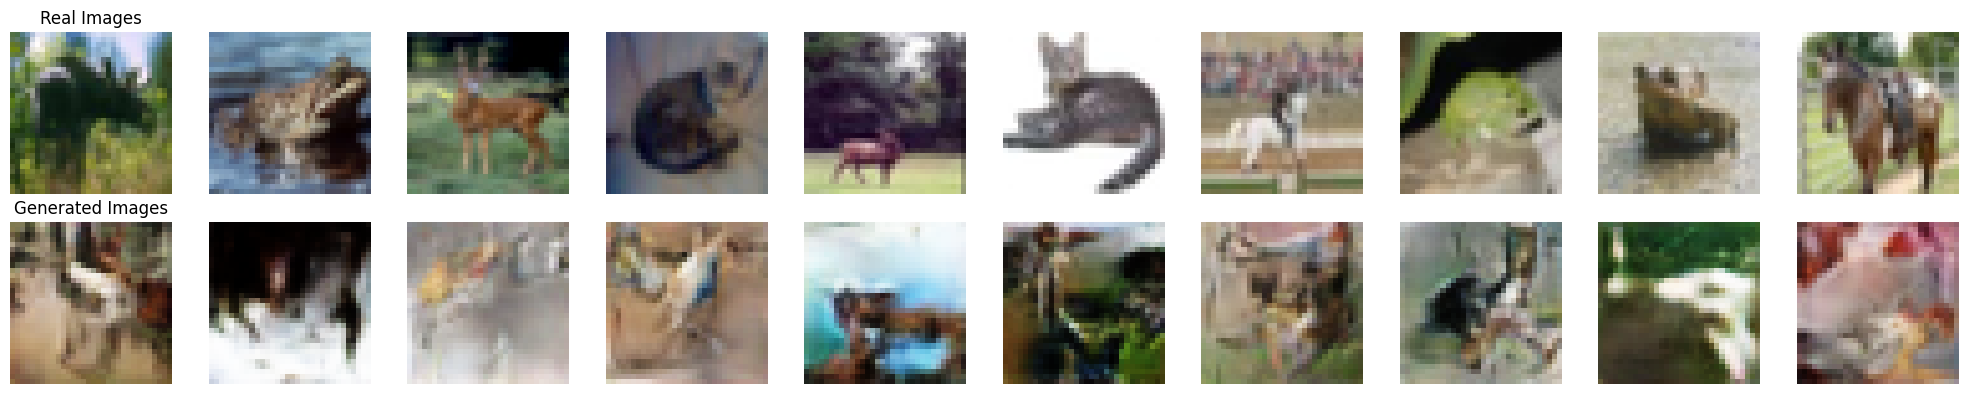

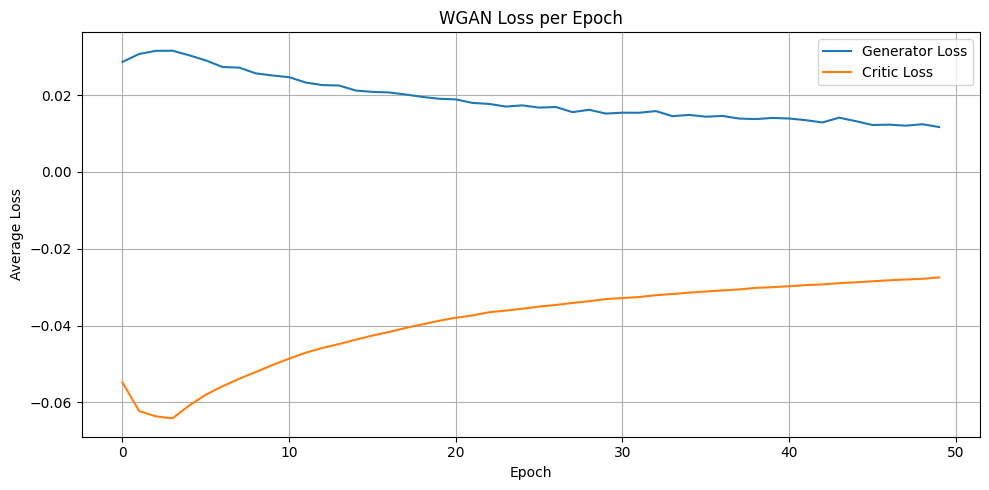

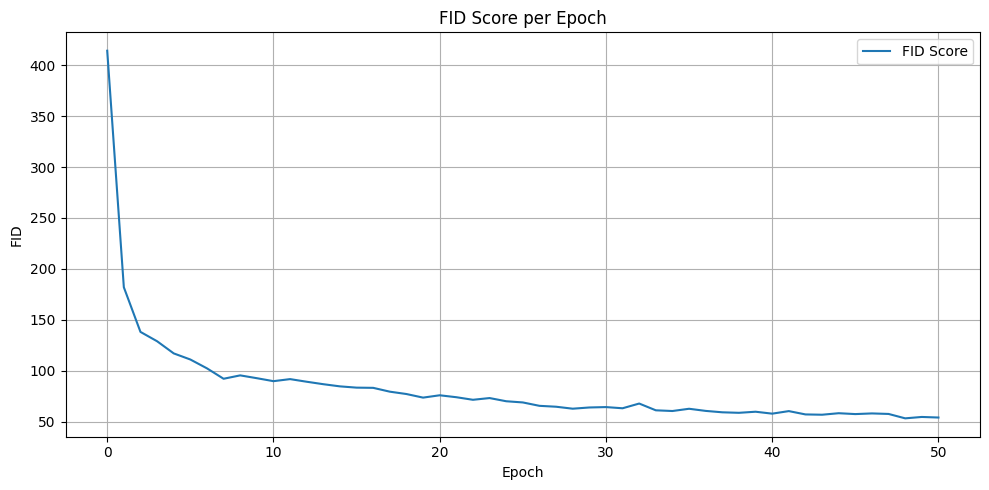

In [16]:
generator_1 = Generator(latent_dim).to(device)
critic_1 = Critic_1().to(device)
optimizer_g1 = optim.RMSprop(generator_1.parameters(), lr=lr)
optimizer_c1 = optim.RMSprop(critic_1.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_1(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val = evaluate_fid(generator_1, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_1 = train_WGAN(generator_1, critic_1, optimizer_g1, optimizer_c1, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

In [ ]:
import pickle
pickle.dump(fid_1, open('fid_no_dropout.pkl', 'wb'))